# EELS SrFeO Project 
## ICA

*Collaboration: M3 Learning at Lehigh University x Dynamic Characterization Group at Drexel University*


#### Some resources to read on ICA

* <span style="color: red"> // put resources here // </span>

### Import Package

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import hyperspy.api as hs
hs.preferences.GUIs.warn_if_guis_are_missing = False

In [15]:
import sklearn
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [16]:
#data = hs.load("processed_data/EELS_raw_*.hdf5")
import pickle
class Container(object): pass
temporal_data = list()
for k in range(19):
    f = pickle.load(open("processed_data/EELS_suprv_"+str(k)+".pkl", 'rb'))
    temporal_data.append(f)

In [17]:
temporal_data[0].O_range.shape

(30, 300, 81)

## Applying RNN Autoencoder to temporal data

In [18]:
temporal_data[0].data.shape

(30, 300, 3710)

### Visualize aggregated signals

Visualizing what we would expect from combined signals. This is just a quality assurance that we didn't do something real wrong. Signals should look smooth and pretty when SNR is high!

Text(0, 0.5, 'counts')

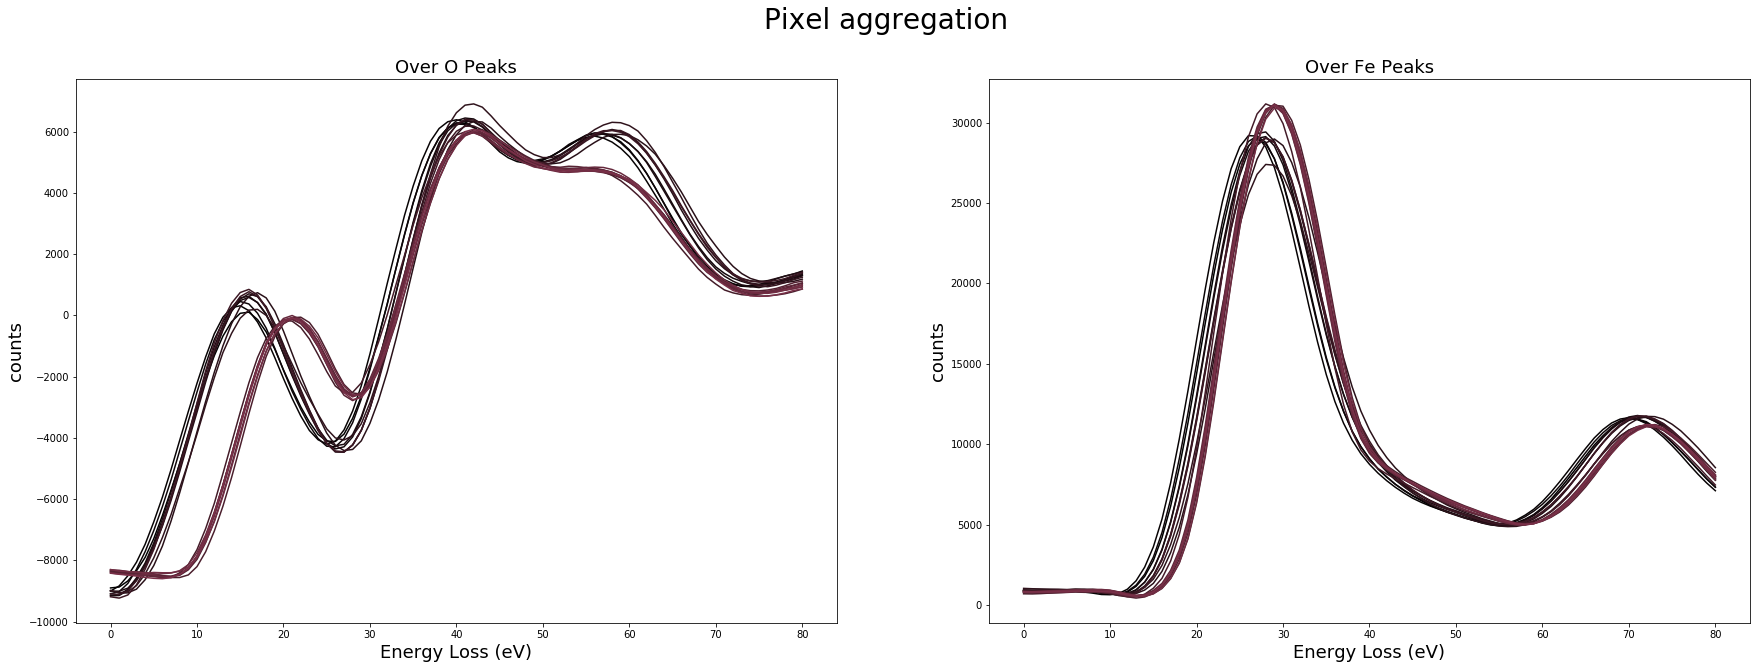

In [19]:
# visualizing raw data

import math

start = 387.5 #eV
stop = 851.25 #eV
step = 0.125 #eV

# Plotting aggregared spectra 
g,(ax3,ax4) = plt.subplots(1,2, figsize=(30,10))
for k in range(len(temporal_data)):
    # Plotting aggregation over oxygen range
    ax3.plot(np.sum(temporal_data[k].O_range, axis=(0,1)), color=(0.5*k/len(temporal_data), 0.2*k/len(temporal_data), 0.3*k/len(temporal_data)))
    # Plotting aggregation over Fe range
    ax4.plot(np.sum(temporal_data[k].Fe_range, axis=(0,1)), color=(0.5*k/len(temporal_data), 0.2*k/len(temporal_data), 0.3*k/len(temporal_data)))

# plot configurations
g.suptitle('Pixel aggregation', fontsize=28)

ax3.set_title('Over O Peaks', fontsize=18)
ax3.set_xlabel('Energy Loss (eV)', fontsize=18)
ax3.set_ylabel('counts', fontsize=18)   

ax4.set_title('Over Fe Peaks', fontsize=18)
ax4.set_xlabel('Energy Loss (eV)', fontsize=18)
ax4.set_ylabel('counts', fontsize=18)  

In [20]:
# rearrange dimension
arrayx = list()
dim = temporal_data[0].O_range.shape
for i in range(len(temporal_data)):
    f = temporal_data[i].O_range.reshape((-1,dim[2]))
    arrayx.append(f)
arrayx = np.array(arrayx).reshape((-1,dim[2]))

In [21]:
arrayx.shape

(171000, 81)

## Setup and run ICA 

In [22]:
numICAcomp = 4
container = list()
for k in range(len(temporal_data)):
    arrayx = np.array(temporal_data[k].O_range[:])
    sha = arrayx.shape
    ica = sklearn.decomposition.FastICA(n_components=numICAcomp, max_iter=2000, tol=0.01)
    ICA = ica.fit(arrayx.reshape((-1,sha[2])))
    ICAembeddings = ICA.transform(arrayx.reshape((-1,sha[2])))[:, 0:numICAcomp].reshape((sha[0],sha[1],-1))
    container.append(ICAembeddings)

In [23]:
container = np.array(container)
container.shape

(19, 30, 300, 4)

## Plot ICA map

fig size: 72.0 DPI, size in inches [6. 6.]


CalledProcessError: Command '['convert', '-size', '480x480', '-depth', '8', '-delay', '30.0', '-loop', '0', 'rgba:-', 'ICA.gif']' died with <Signals.SIGINT: 2>.

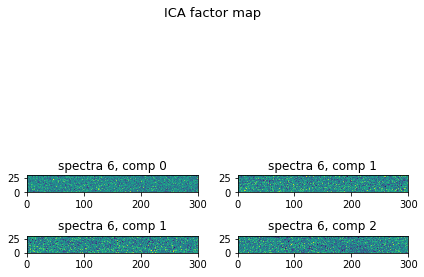

In [24]:

import sys
from matplotlib.animation import FuncAnimation
ax=[]
fig, (ax) = plt.subplots(2,2, figsize=(6,6))
fig.suptitle("ICA factor map", fontsize=13)
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

def update(k):
    label = 'timestep {0}'.format(k)
    for i in range(2):
        for j in range(2):
            pcolor = ax[i,j].pcolor(container[k][:,:,i+j], cmap='viridis')
            ax[i,j].axis('scaled')
            #ax[i].invert_yaxis()
            #pcolor.set_clim(0, 2)
            #fig.colorbar(pcolor)
            ax[i,j].set_title("spectra "+str(k)+", comp "+str(i+j))
    print(label, end='\r')
    return ax

#if __name__ == '__main__':
# FuncAnimation will call the 'update' function for each frame; here
# animating over 10 frames, with an interval of 200ms between frames.
anim = FuncAnimation(fig, update, frames=np.arange(0, len(container)), interval=300)
#if len(sys.argv) > 1 and sys.argv[1] == 'save':
anim.save('ICA.gif', dpi=80, writer='imagemagick')
#else:
    # plt.show() will just loop the animation forever.
#    plt.show()

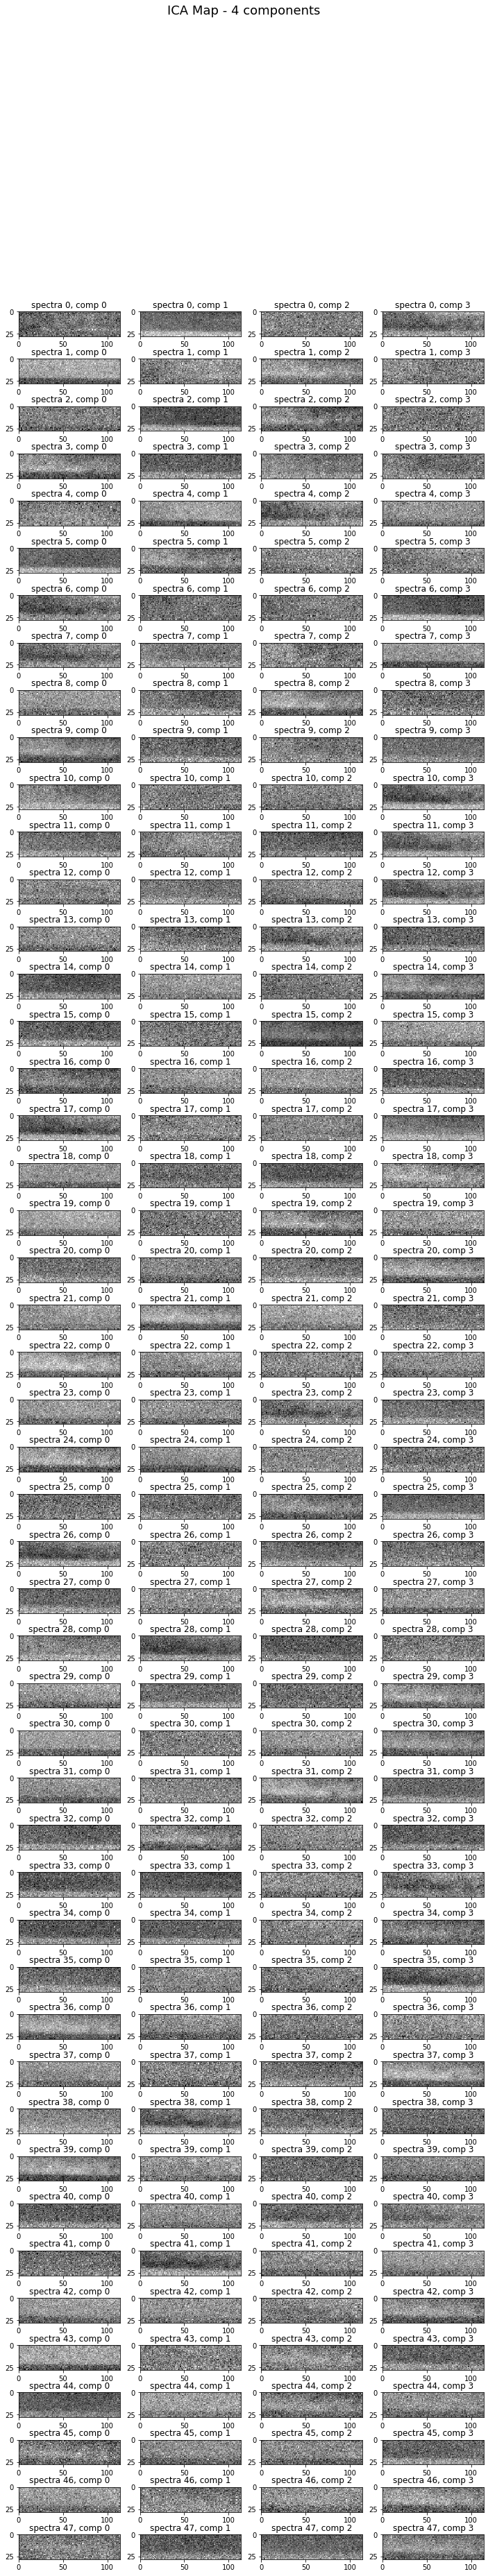

In [25]:
ax=[]
fig,(ax) = plt.subplots(len(container),4, figsize=(12,60))
for k,embed in enumerate(container):
    for i in range(numICAcomp):
        pcolor = ax[k,i].pcolor(embed[:,:,i])
        ax[k,i].axis('scaled')
        ax[k,i].invert_yaxis()
        #pcolor.set_clim(0, 2)
        #fig.colorbar(pcolor)
        ax[k,i].set_title("spectra "+str(k)+", comp "+str(i))
        fig.suptitle("ICA Map - 4 components", fontsize=18)

## Plot ICA component